Figure saved to: ../results/figures/fig13_convex_hull.pdf


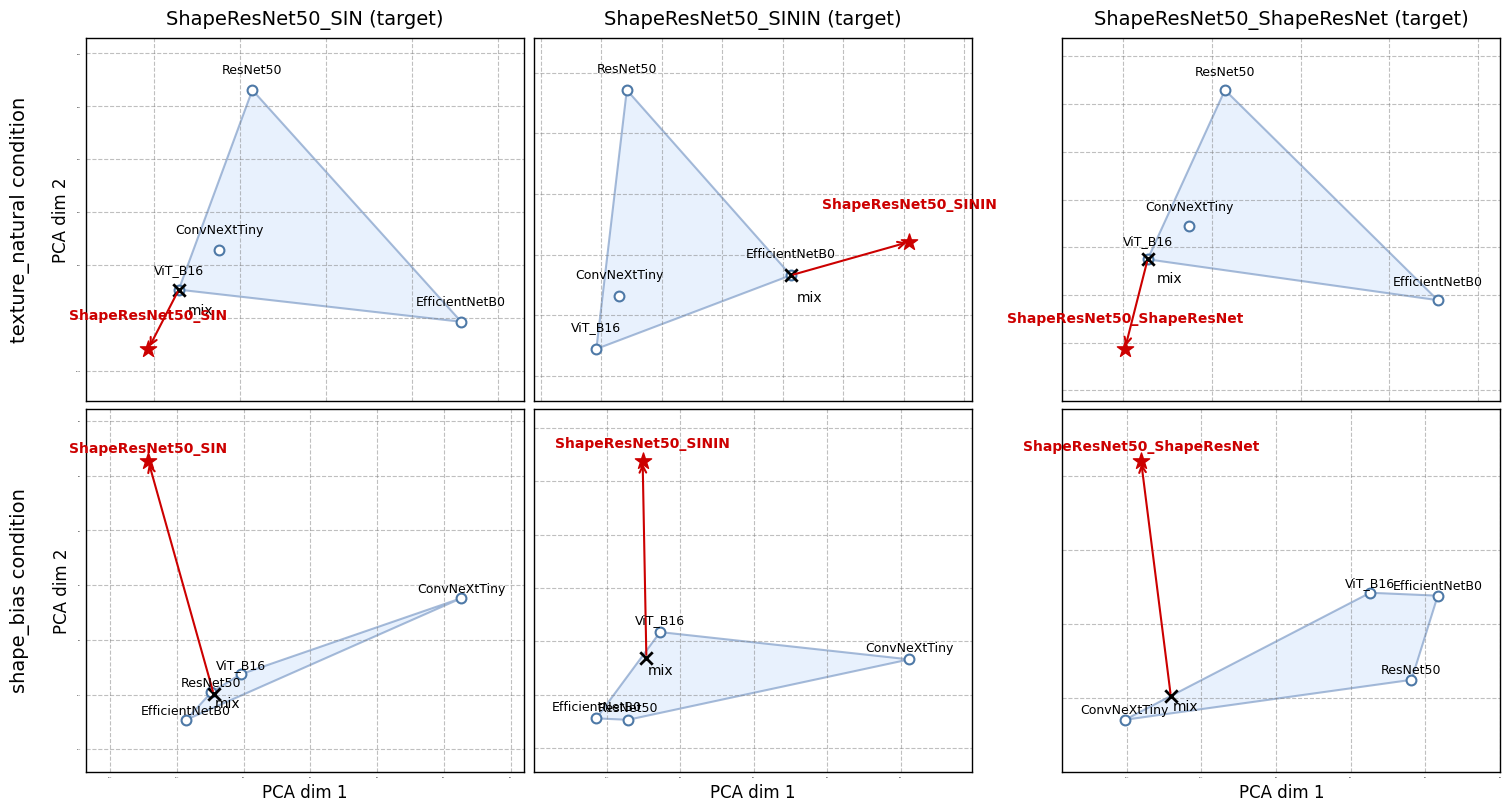

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Configuration
geometry_dir = os.path.join("..", "results", "artifacts", "exp13")
prefix = "exp13_geometry"

shape_targets = [
    "ShapeResNet50_SIN",
    "ShapeResNet50_SININ",
    "ShapeResNet50_ShapeResNet",
]

contexts = ["texture_natural", "shape_bias"]

# Set global font styles to match scientific papers (sans-serif)
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 12,
    "axes.linewidth": 1.0,
    "xtick.major.size": 0,  # Hide tick marks
    "ytick.major.size": 0,
    "xtick.labelsize": 0,   # Hide tick numbers
    "ytick.labelsize": 0,
})

def load_geometry(target_name: str, context: str):
    # Ensure this path logic matches your local setup
    fname = f"{prefix}_{target_name}_{context}.npz"
    path = os.path.join(geometry_dir, fname)
    if not os.path.exists(path):
        # Fallback for testing if file doesn't exist
        print(f"Warning: File not found {path}, returning mock data.")
        return mock_data(target_name) 
    data = np.load(path, allow_pickle=True)
    return data

# Mock data function just in case you run this without files, 
# you can remove this if your files are present.
def mock_data(target_name):
    return {
        "coords": np.random.rand(10, 2),
        "labels": ["ResNet50", "ViT_B16", "ConvNextTiny", "EfficientNetB0"] + ["Peer"]*6,
        "peer_mask": np.array([True]*4 + [False]*6),
        "hull_vertices": [0, 1, 3, 2], # Indices
        "target_idx": 4,
        "mix_idx": 5,
        "explained_variance": [0.8, 0.1],
        "target_name": target_name,
        "l2_dist": 0.0033
    }

# 1. Pre-calculate L2 max for potential scaling (optional)
l2_map = {}
for t in shape_targets:
    for ctx in contexts:
        try:
            d = load_geometry(t, ctx)
            l2_dist_val = float(d["l2_dist"])
            l2_map[(t, ctx)] = l2_dist_val
        except:
            l2_map[(t, ctx)] = 0.0

def format_scientific_latex(value):
    """Converts 0.0033 to 3.3 x 10^-3 string for LaTeX."""
    str_val = "{:.1e}".format(value)
    base, exponent = str_val.split("e")
    return fr"{base} \times 10^{{{int(exponent)}}}"

def plot_geometry_style(ax, data, l2_dist, is_last_col=False):
    coords = data["coords"]
    labels = data["labels"]
    peer_mask = data["peer_mask"]
    hull_vertices = data["hull_vertices"]
    target_idx = int(data["target_idx"])
    mix_idx = int(data["mix_idx"])

    peers_coords = coords[peer_mask]
    peers_labels = labels[peer_mask]
    target_coord = coords[target_idx]
    mix_coord = coords[mix_idx]
    hull_pts = peers_coords[hull_vertices]

    # --- Colors mimicking the reference image ---
    color_hull_fill = "#dae8fc"  # Light Blue
    color_hull_edge = "#6c8ebf"  # Medium Blue
    color_peer_edge = "#4e79a7"  # Standard Blueish
    color_target_red = "#cc0000" # Dark Red
    
    # 1. Draw Convex Hull (Polygon)
    # Ensure the polygon is closed for the visual outline
    poly = Polygon(hull_pts, closed=True, 
                   facecolor=color_hull_fill, 
                   edgecolor=color_hull_edge, 
                   alpha=0.6, linewidth=1.5, zorder=1)
    ax.add_patch(poly)

    # 2. Draw Peer Points (Hollow circles)
    ax.scatter(peers_coords[:, 0], peers_coords[:, 1], 
               facecolors='white', edgecolors=color_peer_edge, 
               s=50, linewidth=1.5, zorder=3)
    
    # Peer Labels
    for name, (x, y) in zip(peers_labels, peers_coords):
        # Simple offset logic to avoid overlap
        ax.text(x, y + 0.0005, name, fontsize=9, ha="center", va="bottom", zorder=5, color="black")

    # 3. Mix Point (Black Cross)
    ax.scatter(mix_coord[0], mix_coord[1], marker="x", s=80, color="black", linewidth=2, zorder=4)
    ax.text(mix_coord[0] + 0.0005, mix_coord[1] - 0.0005, "mix", fontsize=10, va="top", zorder=5)

    # 4. Target Point (Red Star)
    tname = str(data["target_name"])
    ax.scatter(target_coord[0], target_coord[1], marker="*", s=150, color=color_target_red, zorder=5)
    
    # Target Label (Red, next to star)
    ax.text(target_coord[0], target_coord[1] + 0.001, tname, 
            fontsize=10, color=color_target_red, ha="center", va="bottom", fontweight='bold', zorder=6)

    # 5. Residual Arrow (Red)
    ax.annotate("", xy=(target_coord[0], target_coord[1]), xytext=(mix_coord[0], mix_coord[1]),
                arrowprops=dict(arrowstyle="->", color=color_target_red, lw=1.5), zorder=4)

    # 6. L2 Distance Annotation
    # Calculate midpoint for text placement
    mid_x = (mix_coord[0] + target_coord[0]) / 2
    mid_y = (mix_coord[1] + target_coord[1]) / 2
    
    # Offset perpendicular to the line slightly (optional, or just place above)
    latex_val = format_scientific_latex(l2_dist)
    text_str = fr"$\|t - \hat{{t}}\|_2 = {latex_val}$"
    
    # Place text slightly above the arrow
    # ax.text(mid_x, mid_y + 0.0015, text_str, fontsize=11, ha="center", zorder=6)

    # 7. Axes styling
    ax.grid(True, linestyle="--", alpha=0.5, color="gray")
    
    # Set labels
    ax.set_xlabel("PCA dim 1", fontsize=12)
    ax.set_ylabel("PCA dim 2", fontsize=12)

    # Force margins to ensure labels don't get cut off
    ax.margins(x=0.2, y=0.2)


# --- Main Plotting Loop ---

fig, axes = plt.subplots(len(contexts), len(shape_targets), figsize=(15, 8), constrained_layout=True)

for row_idx, ctx in enumerate(contexts):
    for col_idx, target_name in enumerate(shape_targets):
        
        ax = axes[row_idx, col_idx]
        data = load_geometry(target_name, ctx)
        l2_d = l2_map.get((target_name, ctx), 0.0)

        # Plot content
        plot_geometry_style(ax, data, l2_d)

        # --- Title Handling (Column Headers) ---
        if row_idx == 0:
            # Clean up title: "ShapeResNet50_SIN (target)"
            clean_title = f"{target_name} (target)"
            ax.set_title(clean_title, fontsize=14, pad=10)

        # --- Row Label Handling (Left Side) ---
        if col_idx == 0:
            # We add a large text label to the left of the axis
            # This mimics the "texture_natural condition" vertical text
            ax.text(-0.15, 0.5, f"{ctx} condition", 
                    transform=ax.transAxes, 
                    fontsize=14, rotation=90, 
                    va='center', ha='center')

# Remove standard y-labels from inner plots to clean up
for ax in axes.flatten():
    ax.label_outer()

# Save
save_path = os.path.join("../results/figures/", "fig13_convex_hull.pdf")
plt.savefig(save_path, format="pdf", dpi=300, bbox_inches="tight")
print(f"Figure saved to: {save_path}")


# plt.tight_layout() # Using constrained_layout=True in subplots instead
plt.show()